In [1]:
import os, sys
import json
import h5py

import numpy as np
import scipy.stats as scipystats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from shutil import copyfile
from functools import reduce
from analysis.processing.utils import derive_session_type
from analysis.plots.utils import get_colors
from analysis.processing.epochs import get_epochs
from analysis.processing.theta import get_tpp, compute_and_save_tpp
from analysis.processing.metrics import get_field_match
from analysis.adapters.hdf5 import H5NAMES
from analysis.adapters.kwik import load_clu_res_single
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
COLORS = get_colors()

source = '/home/andrey/storage2/andrey/data/processed'
#source = '/storage2/andrey/data/processed'
report = '/home/andrey/storage2/andrey/data/projects/24_shift/theta/group_statistics'
theta_sampling = 1250

In [4]:
def get_sessions(source, animal):
    def is_dir(name):
        return os.path.isdir(os.path.join(source, animal, name))

    def has_h5(name):
        return os.path.exists(os.path.join(source, animal, name, '%s.h5' % H5NAMES.filebase))
    
    return [x for x in os.listdir(os.path.join(source, animal)) if is_dir(x) and has_h5(x)]

In [5]:
def get_spike_bursts(session_path, electrode, unit, condition=None):
    # loading animal trajectory
    h5path = os.path.join(session_path, '%s.h5' % H5NAMES.filebase)
    with h5py.File(h5path, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        running_idxs = np.array(f['running_idxs'])

    # loading unit fields data
    h5path = os.path.join(session_path, '%s.h5' % H5NAMES.filebase)
    unit_name = '%s_%s' % (electrode, unit)
    with h5py.File(h5path, 'r') as f:
        if condition is not None:
            condition_idxs = np.array(f[condition + '_idxs'])
        spike_idxs = np.array(f['units'][unit_name]['spike_idxs'])    
    
    # spiketrain
    if condition is not None:
        spike_idxs = np.intersect1d(spike_idxs, condition_idxs)
    #spike_idxs = np.intersect1d(spike_idxs, running_idxs)
    spike_times = trajectory[spike_idxs]  # times - 0th dimension

    # splitting spiketrain into burtsts separated by time threshold (2 seconds) 
    idxs_of_chunks_idxs = []
    chunk = []
    delta_threshold = 2  # seconds

    for i, delta in enumerate(np.diff(spike_times[:, 0])):
        if delta < delta_threshold:
            chunk.append(i)
        else:
            if len(chunk) > 0:
                chunk.append(i)
                idxs_of_chunks_idxs.append(list(chunk))
            chunk = []

    if len(chunk) > 0:
        idxs_of_chunks_idxs.append(list(chunk))

    spike_burst_idxs = []
    for chunk in idxs_of_chunks_idxs:
        spike_burst_idxs.append(spike_idxs[np.array(chunk)])

    # filter out bursts having less than 20 spikes
    spike_idxs_filt = [x for x in spike_burst_idxs if len(x) > 10]
    
    return spike_idxs_filt

In [6]:
selected_sessions = [
    ('005364', '2020-10-09_16-02-59', '8_2'),  # something there
    ('005364', '2020-10-08_22-25-34', '8_10'), # no presession when dark?
    ('005364', '2020-10-11_12-36-05', '1_8'),  # good TPP, no change bw conditions
    ('003909', '2020-03-27_18-41-37', '2_11'), # kind of disappears A->B
    ('003909', '2020-03-27_18-41-37', '6_7'),  # nice A-B and Ad-Bd, phase shift in dark
    ('003282', '2019-11-21_21-58-48', '7_9'),  # ~nothing
    ('003282', '2019-11-24_20-06-11', '4_10'), # ~nothing
    ('003282', '2019-12-02_17-51-29', '5_10')  # low precession
]

#/storage2/andrey/data/processed/005364/2020-10-09_16-02-59
#/storage2/andrey/data/processed/005364/2020-10-11_12-36-05
#/storage2/andrey/data/processed/003909/2020-03-27_18-41-37


In [7]:
# copy PF figures
#for item in selected_sessions:
#    f_path = os.path.join(source, item[0], item[1], 'analysis', 'placefields')
#    f_name = '%s_%s_%s_%s.png' % (item[0], item[1], item[2], item[3])
#    copyfile(os.path.join(f_path, f_name), os.path.join(report, f_name))

### Build TTP stats

In [8]:
#groups = ((0, 90), (90, 180), (180, 270), (270, 360))
source = '/home/andrey/storage2/andrey/data/processed'
#animals = ['00908', '00910', '002784', '003281', '003282', '003908', '003909', '005363']
animals = ['003281', '003908', '003909', '005363', '005364']
     
stats = []
for animal in animals:
    sessions = get_sessions(source, animal)
    for session in sessions:
        h5path = os.path.join(source, animal, session, '%s.h5' % H5NAMES.filebase)
        if not os.path.exists(h5path):
            continue
        
        s_type = derive_session_type(os.path.join(source, animal, session))
        try:
            conditions = get_epochs(os.path.join(source, animal, session))
        except ValueError:
            print('No epochs for %s %s' % (animal, session))
            continue
        with h5py.File(h5path, 'r') as f:
            for unit_name in f['units']:
                unit_group = f['units'][unit_name]
                isoldist = float(unit_group.attrs['isolation_distance'][0])
                
                for condition in conditions:
                    if not H5NAMES.tpp in unit_group[condition]:
                        continue
                    tpp = np.array(unit_group[condition][H5NAMES.tpp])
                    
                    if len(tpp) < 10:
                        continue

                    sic = float(unit_group[condition][H5NAMES.firing_rate_map].attrs['information_content'])
                    f_ids = np.unique(tpp[:, 0])
                    
                    for f_id in f_ids:
                        # only spikes 0.4m around place field
                        tpp_m = np.array( tpp[(tpp[:, 0] == f_id) & (tpp[:, 5] < 0.3)] )
                        th0_mean = scipystats.circmean(tpp_m[:, 7])
                        
                        if len(tpp_m) < 10:
                            continue
                            
                        tpp_m[:, 7] = ((tpp_m[:, 7] + (3/4)*np.pi)*180/np.pi) % 360  # work in grad

                        data = []
                        bins = np.array([(i*np.pi/8, i*np.pi/8 + np.pi/2) for i in range(16)])*180/np.pi % 360
                        for l_bin, r_bin in bins:
                            if l_bin < r_bin:
                                on_that_phase = tpp_m[(tpp_m[:, 7] >= l_bin) & (tpp_m[:, 7] < r_bin)]
                            else:
                                on_that_phase = tpp_m[(tpp_m[:, 7] >= l_bin) | (tpp_m[:, 7] < r_bin)]
                            if len(on_that_phase) > 0:
                                # just Y-projection
                                data.append(on_that_phase[:, 3])
                                # R with Y-projection sign - too noisy
                                #data.append(np.sign(on_that_phase[:, 3]) * on_that_phase[:, 5])
                            
                        if not len(data) > 1:
                            continue
                            
                        # delta TPP, phases of min/max
                        medians = np.array([np.median(x) for x in data])
                        spike_counts = np.array([len(x) for x in data])
                        spk_cnt = bins[:, 0][ spike_counts.argmin() ]
                        phi_min = bins[:, 0][ medians.argmin() ]
                        phi_max = bins[:, 0][ medians.argmax() ]
                        delta = medians.max() - medians.min()
                            
                        st, pv = scipystats.kruskal(*data)
                        stats.append([animal, session, s_type, unit_name, condition, f_id, isoldist, sic, \
                                      st, pv, phi_min, phi_max, delta, spk_cnt, th0_mean])

    print('Animal %s done' % animal)

columns = ['animal', 'session', 'type', 'unit', 'condition', 'field_id', 'iso', 'sic', \
           'st', 'pv', 'phi_min', 'phi_max', 'delta', 'spk_cnt', 'th0_mean']
df = pd.DataFrame(stats, columns=columns)                        

No epochs for 003281 2019-12-01_16-07-29
No epochs for 003281 2019-12-02_14-43-34
Animal 003281 done
Animal 003908 done
Animal 003909 done
Animal 005363 done
Animal 005364 done


In [9]:
dfs = df[(df['sic'] > 0.2) & (df['iso'] > 15) & (df['pv'] < 0.05)]
dfs.head()

animal              session            type unit condition  field_id  \
11  003281  2019-10-22_10-12-05  SHIFT periodic  2_4         B       2.0   
12  003281  2019-10-22_10-12-05  SHIFT periodic  2_5         A       1.0   
21  003281  2019-10-21_22-25-20  SHIFT periodic  2_2         B       1.0   
24  003281  2019-10-21_22-25-20  SHIFT periodic  2_3         B       1.0   
38  003281  2019-10-21_22-25-20  SHIFT periodic  2_7         A       1.0   

          iso       sic          st            pv  phi_min  phi_max     delta  \
11  24.962440  0.302263   31.029709  8.704811e-03    202.5    337.5  0.086727   
12  23.300796  0.372470   44.885717  7.981778e-05    157.5     22.5  0.133553   
21  17.949902  0.715320   28.686542  1.764596e-02     90.0    225.0  0.135003   
24  17.684590  0.226853   50.527883  9.869242e-06    157.5      0.0  0.094682   
38  24.129818  0.625541  108.278491  3.448905e-16    135.0      0.0  0.072311   

    spk_cnt  th0_mean  
11    225.0  5.833867  
12    202.5  5.214606  
21    180.0  5.153750  
24    157.5  4.533409  
38    202.5  5.849277

0.45669898463462566 0.6385335123001291 0.5961676549483087


(array([ 1.,  0.,  1.,  0.,  3.,  9., 11.,  3.,  7.,  2.,  0.,  1.,  0.,
         0.,  1.,  1.]),
 array([  0.     ,  21.09375,  42.1875 ,  63.28125,  84.375  , 105.46875,
        126.5625 , 147.65625, 168.75   , 189.84375, 210.9375 , 232.03125,
        253.125  , 274.21875, 295.3125 , 316.40625, 337.5    ]),
 <BarContainer object of 16 artists>)

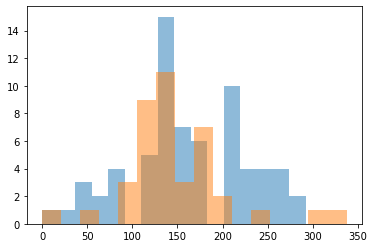

In [278]:
df_gain_A = dfs[(dfs['condition'] == 'A') & (dfs['type'].str.contains('both'))]
df_gain_B = dfs[(dfs['condition'] == 'Ad') & (dfs['type'].str.contains('both'))]

st_dt, pv_dt = scipystats.ttest_ind(df_gain_A['delta'], df_gain_B['delta'])
st_phi_min, pv_phi_min = scipystats.ttest_ind(df_gain_A['phi_min'], df_gain_B['phi_min'])
st_phi_max, pv_phi_max = scipystats.ttest_ind(df_gain_A['phi_max'], df_gain_B['phi_max'])

print(pv_dt, pv_phi_min, pv_phi_max)

#plt.hist(dfs['delta'], 30)
plt.hist(df_gain_A['spk_cnt'], 16, alpha=0.5)
plt.hist(df_gain_B['spk_cnt'], 16, alpha=0.5)
#plt.hist(dfs['phi_max'], 16)

### TPP persistance cond A -> cond B

In [27]:
def get_tpp_stats_between_fields(df, exp_substr, cond_A, cond_B):
    data = []
    df_A = df[(df['condition']==cond_A) & (df['type'].str.contains(exp_substr))]
    
    for i, rec in df_A.iterrows():
        h5path = os.path.join(source, rec['animal'], rec['session'], '%s.h5' % H5NAMES.filebase)
        electrode, unit = rec['unit'].split('_')[0], rec['unit'].split('_')[1]

        fmatch = get_field_match(h5path, electrode, unit, rec['field_id'], rec['condition'], cond_B)
        if fmatch is None:
            continue

        field_match, shift = fmatch

        df_f = df[(df['animal']==rec['animal']) & (df['session']==rec['session']) & (df['unit']==rec['unit']) & \
                   (df['condition'] == cond_B) & (df['field_id']==field_match)]

        if not len(df_f) > 0:  # no matching field found in stats
            continue
            
        match = df_f.iloc[0]
        data.append([rec['st'], rec['pv'], rec['phi_min'], rec['phi_max'], rec['delta'], rec['th0_mean'],\
                     match['st'], match['pv'], match['phi_min'], match['phi_max'], match['delta'], match['th0_mean'], \
                     shift])

    columns = ['st_A', 'pv_A', 'phi_min_A', 'phi_max_A', 'delta_A', 'th0_mean_A', \
               'st_B', 'pv_B', 'phi_min_B', 'phi_max_B', 'delta_B', 'th0_mean_B', 'shift']
    if len(data) > 0:
        return pd.DataFrame(np.array(data), columns=columns)
    return None

In [40]:
exp_substr = '1.4x'
cond_A, cond_B = 'C', 'D'
df_filt = df[(df['sic'] > 0.2) & (df['iso'] > 15)]# & (df['pv'] < 0.05)]

data = get_tpp_stats_between_fields(df_filt, exp_substr, cond_A, cond_B)

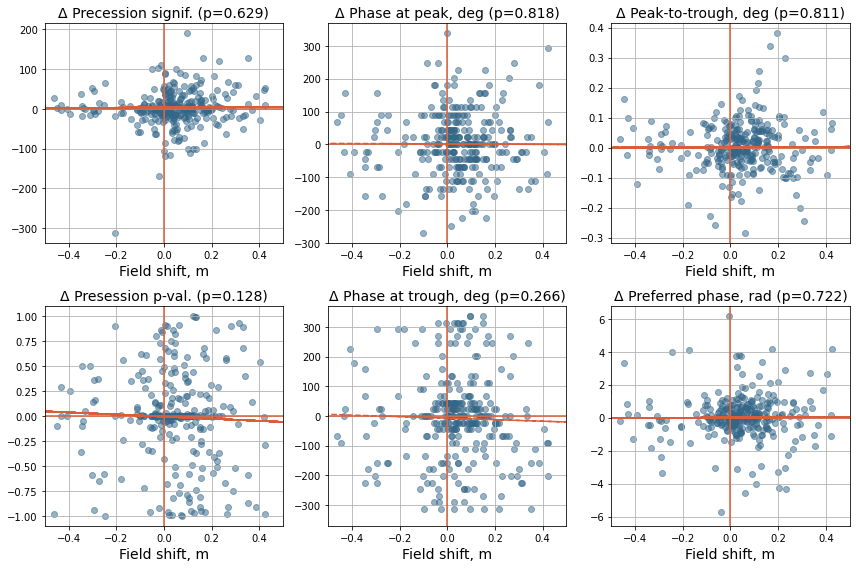

In [41]:
fig = plt.figure(figsize=(12, 8))

titles = {
    'st': 'Precession signif.',
    'pv': 'Presession p-val.',
    'phi_min': 'Phase at peak, deg',
    'phi_max': 'Phase at trough, deg',
    'delta': 'Peak-to-trough, deg',
    'th0_mean': 'Preferred phase, rad'
}

for i, stat in enumerate(['st', 'phi_min', 'delta', 'pv', 'phi_max', 'th0_mean']):
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xlim(-0.5, 0.5)

    x_vals = data['shift']  # field shift
    y_vals = data['%s_B' % stat] - data['%s_A' % stat]  # diff in statistic

    ax.scatter(x_vals, y_vals, color=COLORS['a'], alpha=0.5)
    ax.axhline(0, color=COLORS['b'])
    ax.axvline(0, color=COLORS['b'])
    ax.set_xlabel('Field shift, m', fontsize=14)

    slope, intercept, r_value, p_value, std_err = scipystats.linregress(x_vals, y_vals)
    ax.plot(x_vals, intercept + slope*x_vals, ls='--', color=COLORS['b'])
    ax.set_title('\u0394 %s (p=%.3f)' % (titles[stat], p_value), fontsize=14)
    ax.grid()
    
fig.tight_layout()

filename = "vGAIN_%s_%s-%s.png" % (exp_substr, cond_A, cond_B)
fig.savefig(os.path.join(os.path.join(report), filename))

In [66]:
dfs['type'].unique()

array(['SHIFT periodic', 'GAIN centered 30', 'GAIN 3 parts 1.4x',
       'SHIFT visual', 'SHIFT both', 'SHIFT periodic +dark',
       'GAIN 3 parts 1.2x', 'SHIFT visual +dark', 'SHIFT both +dark',
       'SHIFT single +dark', 'SHIFT visual long +dark'], dtype=object)

### TTP for a session/field for each condition

In [68]:
# selecting A-B pairs with high PP value
df_A = dfs[(dfs['st'] > 40) & (dfs['condition'] == 'A')].copy()
df_B = dfs[(dfs['st'] > 40) & (dfs['condition'] == 'B')].copy()

df_A['condition'] = 'merge'
df_B['condition'] = 'merge'

df_A = df_A.add_prefix('a_')
df_B = df_B.add_prefix('b_')

df_AB = df_A.merge(df_B, left_on=['a_animal', 'a_session', 'a_unit', 'a_field_id', 'a_condition'], \
       right_on=['b_animal', 'b_session', 'b_unit', 'b_field_id', 'b_condition'], how='inner')

# filter by type
df_AB = df_AB[df_AB['a_type'].isin(['SHIFT periodic +dark', 'GAIN 3 parts 1.2x', 'SHIFT visual +dark', 'SHIFT single +dark'])]
df_ABr = df_AB.reset_index()

In [139]:
selected = df_ABr[df_ABr.index.isin([0, 1, 9, 11, 12, 13, 23, 27, 28, 30])]

In [142]:
# copy figures
dest = '/home/andrey/storage2/andrey/data/projects/24_shift/debug'

# delete files inside debug
for f in os.listdir(dest):
    os.remove(os.path.join(dest, f))

for i, row in selected.iterrows():
    f_path = os.path.join(source, row['a_animal'], row['a_session'], 'analysis', 'placefields')
    f_name = '%s_%s_%s_%s.png' % (row['a_animal'], row['a_session'], row['a_unit'].split('_')[0], row['a_unit'].split('_')[1])
    copyfile(os.path.join(f_path, f_name), os.path.join(dest, f_name))

In [144]:
idx = 27

if 1:
    animal = df_AB['a_animal'].iloc[idx]
    session = df_AB['a_session'].iloc[idx]
    unit_name = df_AB['a_unit'].iloc[idx]
    field_id = df_AB['a_field_id'].iloc[idx]
    condition = 'A'
else:
    animal, session, unit_name = selected_sessions[idx]
    condition = 'A'
    field_id = 1
    
tpps = {}  # dict of TTPs for each condition
session_path = os.path.join(source, animal, session)
h5path = os.path.join(session_path, '%s.h5' % H5NAMES.filebase)

electrode, unit = unit_name.split('_')[0], unit_name.split('_')[1]
field_match, shift = get_field_match(h5path, electrode, unit, field_id, 'A', 'B')
if field_match is None:
    raise ValueError('Matching field dont exist.')

conditions = [(condition, field_id), ('B', field_match)]
conditions = [(key, 1) for key in get_epochs(session_path).keys()]

with h5py.File(h5path, 'r') as f:
    for condition, f_id in conditions:
        tpp = np.array(f['units'][unit_name][condition][H5NAMES.tpp])
        tpps[condition] = tpp[tpp[:, 0]==f_id]

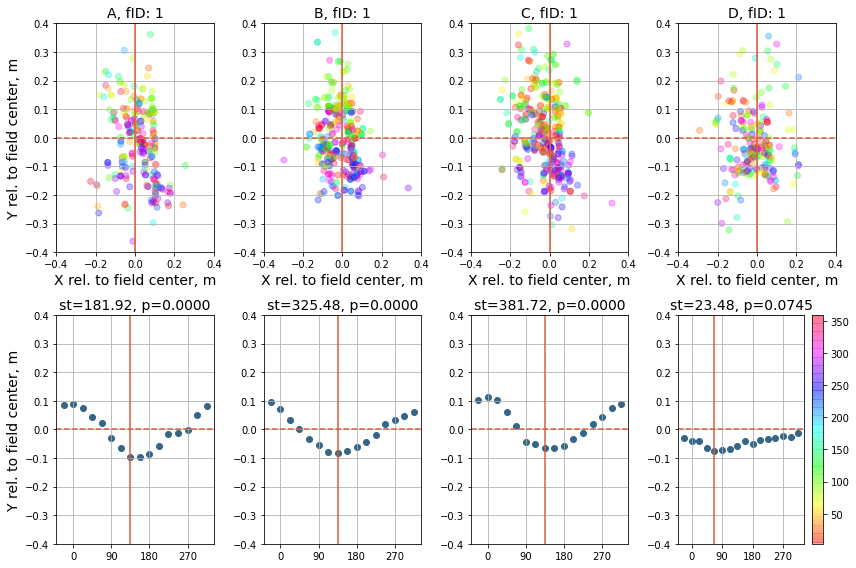

In [182]:
groups = ((0, 90), (90, 180), (180, 270), (270, 360))
#groups = ((-45, 45), (45, 135), (135, 225), (225, 315))

fig = plt.figure(figsize=(12, 8))
col_num = len(conditions)

for i, (condition, f_id) in enumerate(conditions):
    tpp = tpps[condition]
    mask = tpp[:, 1] > 0  # plot all spikes
    mask = tpp[:, 5] < 0.4  # only spikes 0.3m around place field

    # scatter plot
    ax = fig.add_subplot(2, col_num, i + 1)
    sc = ax.scatter(tpp[mask][:, 4], tpp[mask][:, 3], c=tpp[mask][:, 7]*180/np.pi + 180, cmap='hsv', alpha=0.3)

    ax.set_title("%s, fID: %d" % (condition, f_id), fontsize=14)
    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.4, 0.4)
    ax.set_xlabel('X rel. to field center, m', fontsize=14)
    if i == 0:
        ax.set_ylabel('Y rel. to field center, m', fontsize=14)
    ax.axvline(0, color=COLORS['b'])
    ax.axhline(0, color=COLORS['b'], ls='--')
    ax.grid()
    
    # boxplot
    tpp_m = np.array(tpp[mask])
    tpp_m[:, 7] = ((tpp_m[:, 7] + (3/4)*np.pi)*180/np.pi) % 360
    #tpp_m[:, 7] = (tpp_m[:, 7])*180/np.pi
    
    #data = []
    #for group in groups:
    #    data.append(tpp_m[(tpp_m[:, 7] >= group[0]) & (tpp_m[:, 7] < group[1])][:, 3])
    data = []
    bins = np.array([(i*np.pi/8, i*np.pi/8 + np.pi/2) for i in range(16)])*180/np.pi % 360
    for l_bin, r_bin in bins:
        if l_bin < r_bin:
            on_that_phase = tpp_m[(tpp_m[:, 7] >= l_bin) & (tpp_m[:, 7] < r_bin)]
        else:
            on_that_phase = tpp_m[(tpp_m[:, 7] >= l_bin) | (tpp_m[:, 7] < r_bin)]
            
            
        if len(on_that_phase) > 0:
            # just Y-projection
            data.append(on_that_phase[:, 3])
            # R with Y-projection sign
            #data.append(np.sign(on_that_phase[:, 3]) * on_that_phase[:, 5])
                
    ax1 = fig.add_subplot(2, col_num, i + col_num + 1)
    #res = ax1.boxplot(data)  # boxplot
    means = np.array([np.median(x) for x in data])
    ax1.scatter(np.arange(16), means, color=COLORS['a']) # just medians
    ax1.axhline(0, color=COLORS['b'], ls='--')
    ax1.axvline(np.argmin(means), color=COLORS['b'])
    
    ax1.set_ylim(-0.4, 0.4)
    if i == 0:
        ax1.set_ylabel('Y rel. to field center, m', fontsize=14)    
    st, pv = scipystats.kruskal(*data)
    ax1.set_title('st=%.2f, p=%.4f' % (st, pv), fontsize=14)
    ax1.get_xaxis().set_ticks([1, 5, 9, 13])
    ax1.get_xaxis().set_ticklabels([0, 90, 180, 270])
    ax1.grid()

plt.colorbar(sc)
fig.tight_layout()

In [181]:
np.argmin(means)

4

### Single bursts

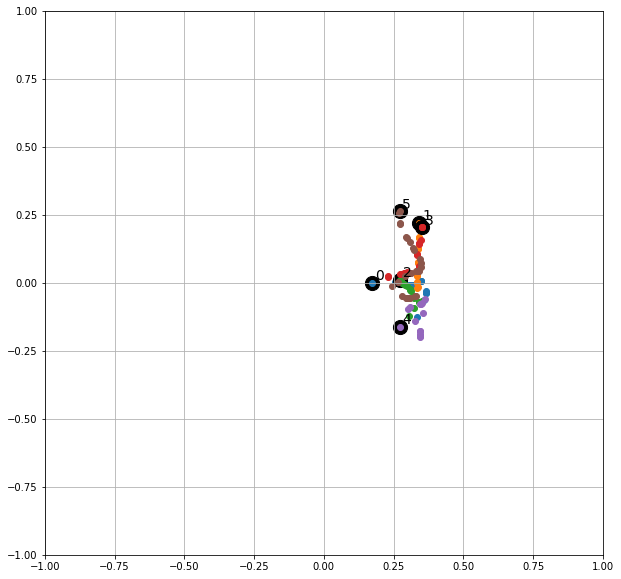

In [565]:
session_path = os.path.join(source, animal, session)
h5path = os.path.join(session_path, '%s.h5' % H5NAMES.filebase)
with h5py.File(h5path, 'r') as f:
    traj = np.array(f['animal_trajectory'])

bursts = get_spike_bursts(session_path, electrode, unit, 'A')
#bursts.sort(key=lambda x: -len(x))

idxs = np.arange(len(bursts))  # all bursts
#idxs = (5, 6, 8)  # relatively good bursts for '003282', '2019-11-24_20-06-11', '4_10'

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
#ax.scatter(0.05936261, 0.47636362, s=400, color='red')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.grid()

for burst_id in idxs[:]:
    sel = traj[bursts[burst_id]]
    ax.scatter(sel[:, 1][0], sel[:, 2][0], s=200, color='black')
    ax.scatter(sel[:, 1], sel[:, 2])
    ax.annotate(str(burst_id), (sel[:, 1][0] + 0.01, sel[:, 2][0] + 0.01), fontsize=14)

In [34]:
### CSD for #00911

In [ ]:
sessions = [
    '2019-07-22_15-41-08',  # 33 - 64 are empty. Has a broken period closer to the beginning.
    '2019-07-22_16-43-01',  # 33 - 64 are empty. Has a broken period closer to the beginning.
    '2019-07-23_10-29-44',
    '2019-07-23_11-36-15',
    '2019-07-23_14-55-07',
    '2019-07-23_15-54-57',
    '2019-07-24_15-56-27',
    '2019-07-24_16-58-23',
    '2019-07-25_10-23-11',
    '2019-07-25_11-19-55', # bad: 2, 21, 22, 24, 26, 29
    '2019-07-25_16-51-17', # bad: 2, 21, 22, 23, 24, 26, 29
    
    
]